In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
import numba.cuda

In [2]:
# if this doesn't work you don't have a compatible GPU!
!nvidia-smi

Sun Feb 25 21:21:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:2E:00.0 Off |                  N/A |
|  0%   52C    P5              69W / 350W |      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Stochastic Differential Equations (SDEs) and Euler-Maruyama Method

## What is a Stochastic Differential Equation (SDE)?

A Stochastic Differential Equation (SDE) is a differential equation in which one or more of the terms is a stochastic process, resulting in a solution that is itself a stochastic process. SDEs are used to model systems that are influenced by random noise or uncertainty.

## Brownian Motion with Drift and Volatility

Brownian motion with drift and volatility models the random movement of a particle or financial asset prices over time, incorporating both a systematic trend and random variation.

## Why are SDEs Useful in Finance?

SDEs model the price movements of financial assets, aid in risk management, and contribute to strategies in portfolio optimization, interest rate modeling, and more.

## Euler Method for Simulating SDEs

The Euler-Maruyama method is a numerical technique used to approximate the solutions of SDEs by discretizing time into small steps and iteratively calculating the value of the stochastic process at each time step.

# Stochastic Differential Equations (SDEs) with Numba and CuPy

## Introduction

This notebook demonstrates the simulation of Stochastic Differential Equations (SDEs) using Python. It includes explanations and code for using traditional methods, optimizations with Numba, and leveraging GPU acceleration with CuPy and Numba.

In [3]:
# Parameters
mu = 0.1  # Drift coefficient
sigma = 0.2  # Volatility coefficient
X0 = 1.0  # Initial value of the process
T = 1.0  # Total time
N = 1000  # Number of time steps

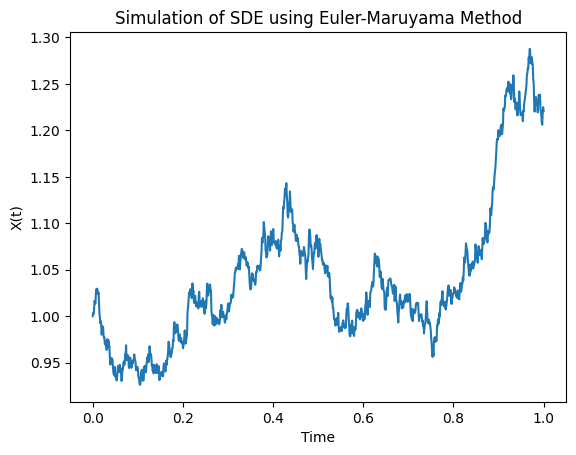

In [4]:
dt = T/N  # Time step size

# Time vector
t = np.linspace(0, T, N)

# Pre-generated matrix of standard normal variates
np.random.seed(42)  # Seed for reproducibility
dW = np.random.normal(0, np.sqrt(dt), size=N)

# Initialize the process values array
X = np.zeros(N)
X[0] = X0

# Naive un-optimized implementation of Euler-Maruyama method on CPU
for i in range(1, N):
    X[i] = X[i-1] + mu*X[i-1]*dt + sigma*X[i-1]*dW[i-1]

# Plotting the simulated SDE path
plt.plot(t, X)
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Simulation of SDE using Euler-Maruyama Method')
plt.show()
    

That code illustrates how the simulation works, but it's not very performant. It's also happening on the CPU, which means it can't be included in an ML workflow that's happening on the GPU.

# Simulation using CuPy and Numba on GPU

## CUDA Threads and Blocks

**CUDA** (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA for general computing on its own GPUs (Graphics Processing Units). Understanding the concepts of threads and blocks is crucial for leveraging CUDA's capabilities for parallel computations.

### CUDA Threads:
In CUDA, a **thread** is the smallest unit of execution. Each thread has its own set of registers and local memory, and it executes a specified function, known as a kernel. Threads are extremely lightweight and are designed to execute in parallel, allowing for the efficient parallel processing of tasks. The programmer can define a multidimensional grid of threads, where each thread is uniquely identified by its index within the grid.

Threads are grouped into blocks, which brings us to the next concept.

### CUDA Blocks:
A **block** is a group of threads that execute the same kernel code. Threads within the same block can communicate with each other and synchronize their execution, facilitating efficient parallel algorithms. This is primarily done through shared memory available to all threads within a block, which offers much faster access times compared to global memory accessible by all threads and blocks.

Blocks are organized into a grid, where each block in the grid can be identified by its block index. Blocks can also be multidimensional, allowing for a flexible mapping of computation tasks to the CUDA architecture.

### Key Points:
- **Parallel Execution**: Threads within the same block can execute in parallel, and multiple blocks can execute simultaneously on different SMs (Streaming Multiprocessors) within a GPU, harnessing the full power of the GPU for parallel computations.
- **Memory Hierarchy**: CUDA provides a hierarchy of memory accessible by threads, including local memory (per thread), shared memory (per block), and global memory (across all threads and blocks). Efficient use of this memory hierarchy is key to optimizing CUDA applications.
- **Synchronization**: Threads within a block can be synchronized, ensuring that all threads reach certain points in the execution together. This is crucial for operations that depend on the results of other threads within the same block.

Understanding and effectively utilizing threads and blocks is fundamental to achieving high performance in CUDA applications. By dividing tasks into manageable chunks that can be processed in parallel by threads organized into blocks, developers can achieve significant speedups for a wide range of computational tasks.


### SDE simluation on GPU

Here are the parameters we will be using

In [5]:
mu = 0.1  # Drift coefficient
sigma = 0.2  # Volatility coefficient
X0 = 1.0  # Initial value
T = 1.0  # Total time
N = 1024  # Time steps
paths = 1000000  # Number of paths

Note that this is a lot of data! 1024 time steps is fairly high resolution for an SDE simulation, and we are simulating 1m paths. 

In [6]:
data_size_mbs=N*paths*8/1024/1024
print(f'the size in memory of the generated MC paths will be {data_size_mbs:.2f} Mbs')

the size in memory of the generated MC paths will be 7812.50 Mbs


Here is the GPU Kernel. Note the decorator `@numba.cuda.jit`, which tells the Python interpreter this is not a normal function, but rather something that is intended to be treated as a CUDA kernel. the `import numba` statement at the top of this workbook is what makes this decorator available.

In [7]:
@numba.cuda.jit
def sde_simulation_cuda(result, random_numbers, mu, sigma, X0, T, N):
    idx = numba.cuda.grid(1) # this tells us which GPU thread we're on-- corresponding to the 
    dt = T / N
    if idx < result.shape[0]: # this if statement is important since 
        X = X0
        for i in range(1, N):
            dW = random_numbers[i-1,idx]  # Use pre-generated random number
            X += mu * X * dt + sigma * X * dW
            result[i,idx] = X

As with the cpu code above, we are simulating the SDE by discretizing in the time domain. Note however that this code only describes creating a single path-- and we want 1m ! We will actually be calling this function on a large number of CUDA blocks.

Two things worth noticing in the code above:
1) `idx=cuda.grid(1)` gets the value of the path we're on, an integer ranging from `0` to `paths-1`. cuda.grid is not normally available in a generic Python function, it will only be available here because of the numba decorator.
2) `if idx<result.shape[0]` is necessary because the number of blocks we launch will be rounded up to ensure we get >= the 1m paths we want. This means that, in the highest block, the last few threads may be more than the 1m datapoints we need. The if statement ensures those specific threads do nothing--otherwise there would be index read/write violations on `result` and `random_numbers`

More on CUDA in a minute.

First we need to generate the random variables, which we will do using cupy.

In [8]:
%%time
dt_sqrt = cp.sqrt(T / N)
random_numbers_gpu = cp.random.normal(0, dt_sqrt, size=(N-1,paths))
print(f'shape of data is {random_numbers_gpu.shape}')

shape of data is (1023, 1000000)
CPU times: user 281 ms, sys: 99.2 ms, total: 380 ms
Wall time: 396 ms


Note how fast that was! We just created 8gb of random data in a few milliseconds! You  can see the memory footprint in the SMI output below.

In [9]:
!nvidia-smi

Sun Feb 25 21:21:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:2E:00.0 Off |                  N/A |
|  0%   59C    P2              44W / 350W |   8070MiB / 24576MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
# create empty container for results
result_gpu = cp.zeros((N,paths), dtype=cp.float32)
result_gpu[0,:] = X0

Running the smi again shows that the memory footprint has increased-- that's the result container

In [11]:
!nvidia-smi

Sun Feb 25 21:21:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:2E:00.0 Off |                  N/A |
|  0%   59C    P2              55W / 350W |  11978MiB / 24576MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
# create numba objects from the cupy objects. Note that there is no memory copy here!
random_numbers_numba = numba.cuda.as_cuda_array(random_numbers_gpu)
result_numba = numba.cuda.as_cuda_array(result_gpu)

In [13]:
# this is a somewhat arbitrary choice, and it can be tuned for performance if needed.
# 256 is a safe choice to use as default.
threads_per_block = 256

In [14]:
# this formula determines how many blocks (rounded up) we need for the number of paths.
# conceptually, this is `paths / threads_per_block` rounded up to the nearest integer.
# this rounding up is important to ensure we have enough blocks for the number of paths.
# note that python has // as the rounded-down division operator. 
blocks_per_grid = (paths + threads_per_block - 1) // threads_per_block

In [15]:
%%time
# now we call the kernel. the first time it will do the jit 
sde_simulation_cuda[blocks_per_grid, threads_per_block](result_numba, random_numbers_numba, mu, sigma, X0, T, N)

CPU times: user 177 ms, sys: 10.3 ms, total: 187 ms
Wall time: 186 ms


In [16]:
%%time
# call again, this time there is no jit
sde_simulation_cuda[blocks_per_grid, threads_per_block](result_numba, random_numbers_numba, mu, sigma, X0, T, N)

CPU times: user 111 µs, sys: 159 µs, total: 270 µs
Wall time: 329 µs


Notice that calling it again takes substantially less time, as we don't have to redo the jit. It's worth noticing that turning the random normals into sde paths is actually way faster than generating the random numbers was. When you're using a highly optimized GPU kernel.

In [17]:
%%time
# copying from GPU ram (on the graphics card) to CPU ram (on motherboard)
result_host = result_gpu.get()

CPU times: user 1.12 s, sys: 331 ms, total: 1.45 s
Wall time: 1.45 s


This is a very slow operation, since we're copying 8gb of data from the VRAM to regular RAM across the PCIe bus (think: the motherboard slot for GPUs). This slowness illustrates our second reason for wanting to do the MC on GPU. Not only is it way faster than CPU, but if we're using this MC as part of a larger AI workflow, we need the data on the GPU anyway.

In reality though it should never be necessary to do copy raw MC scenarios like this, we'll usually only be interested in downstream results (eg trained nn parameters, which are much smaller in size).

In [18]:
t = cp.linspace(0, T, N).get()

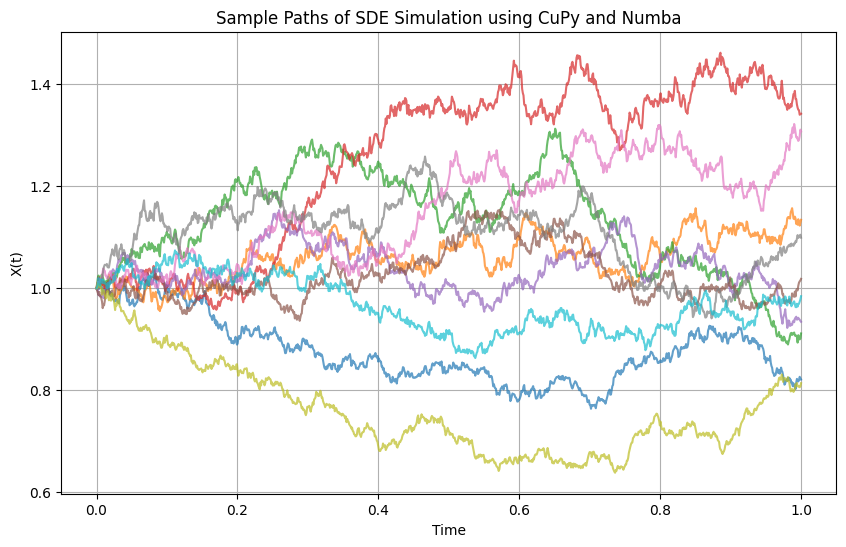

In [19]:
plt.figure(figsize=(10, 6))
for i in range(min(10, paths)):
    plt.plot(t, result_host[:,i], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Sample Paths of SDE Simulation using CuPy and Numba')
plt.grid(True)
plt.show()

This is just a basic Geometric Brownian motion, however simulating more complex SDEs (including multivariate ones) would work exactly the same way programatically. Follow this pattern and you should have very high performance.